# Reproducibility with original data

This tutorial demonstrates deconvolution to map cell types of the mouse cortex from sc-RNA-seq data to Visium data using Pysodb and Tangram.

A reference paper can be found at https://www.nature.com/articles/s41592-021-01264-7.

This tutorial refers to the following tutorial at https://squidpy.readthedocs.io/en/stable/external_tutorials/tutorial_tangram.html. At the same time, the way of loadding data is modified by using Pysodb.

The single cell data utilized in the tutorial can be accessed directly from Figshare at https://figshare.com/articles/dataset/Visium/22332667.

## Import packages and set configurations

In [1]:
# Import several Python packages, including:
# scanpy: a Python package for single-cell RNA sequencing analysis
import scanpy as sc
# squidpy: a Python package for spatial transcriptomics analysis
import squidpy as sq
# numpy: a Python package for scientific computing with arrays
import numpy as np
# pandas: a Python package for data manipulation and analysis
import pandas as pd

In [2]:
# Import tangram for spatial deconvolution
import tangram as tg

In [3]:
# print a header message, and the version of the squidpy and tangram packages
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
print(f"tangram=={tg.__version__}")

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8
squidpy==1.2.3
tangram==1.0.4


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import palettable

adjusted_qualitative_colors = [
    '#5e81ac', '#f47b56', '#7eaca9', '#e28b90', '#ab81bd', '#b68e7e', '#df8cc4', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5',
    '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39'
]

# Create adjusted custom qualitative colormap
adjusted_qualitative_cmap = ListedColormap(adjusted_qualitative_colors)

# Example of using the custom colormap with Scanpy
# sc.pl.umap(adata, color='gene_name', cmap=adjusted_qualitative_cmap)
cmp_ct = palettable.cartocolors.qualitative.Safe_10.mpl_colors

## Load a single cell dataset

In [5]:
# Load the reference single cell dataset
# The input sc data has been normalized and log-transformed
adata_sc = sc.read_h5ad('data/Visium/sc_mouse_cortex.h5ad')

In [6]:
# Print out the metadata of adata_sc
adata_sc

AnnData object with n_obs × n_vars = 21697 × 36826
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_class_colors', 'cell_subclass_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

<Axes: title={'center': 'cell_subclass'}, xlabel='UMAP1', ylabel='UMAP2'>

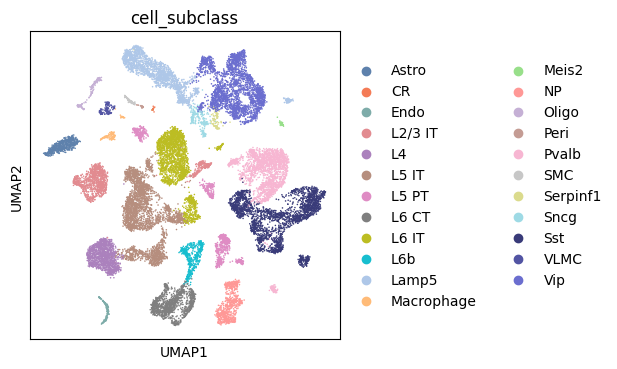

In [7]:
# Visualize a UMAP projection colored by cell_subclass
fig,ax = plt.subplots(figsize=(4,4))
sc.pl.embedding(adata_sc,basis='umap',color=['cell_subclass'],ax=ax,show=False,palette=adjusted_qualitative_colors,s=5)

## Streamline development of loading spatial data with Pysodb

In [8]:
# Import pysodb package
# Pysodb is a Python package that provides a set of tools for working with SODB databases. 
# SODB is a format used to store data in memory-mapped files for efficient access and querying. 
# This package allows users to interact with SODB files using Python.
import pysodb

In [9]:
# Initialization
sodb = pysodb.SODB()

In [10]:
# Define the name of the dataset_name and experiment_name
dataset_name = 'Biancalani2021Deep'
experiment_name = 'visium_fluo_crop'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_st = sodb.load_experiment(dataset_name,experiment_name)

load experiment[visium_fluo_crop] in dataset[Biancalani2021Deep]


In [11]:
adata_st

AnnData object with n_obs × n_vars = 704 × 16562
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

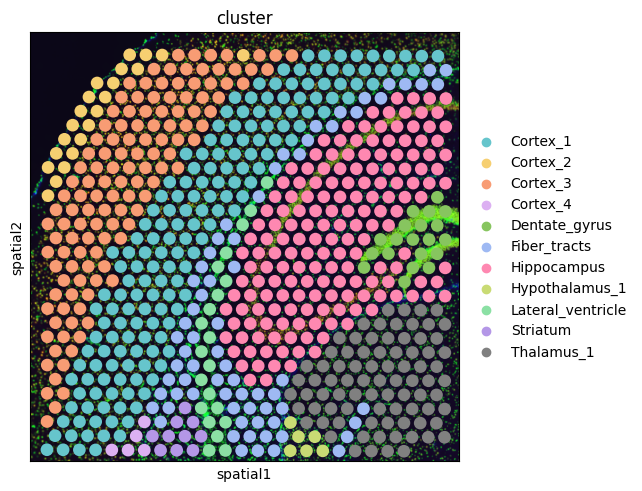

In [12]:
# Create a spatial scatter plot colored by cluster label
cmp_ct = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct.append('gray')
cmp_ct_cmp = ListedColormap(cmp_ct)

ax = sq.pl.spatial_scatter(adata_st,color='cluster',size=1.2,palette=cmp_ct_cmp)

## Preparation

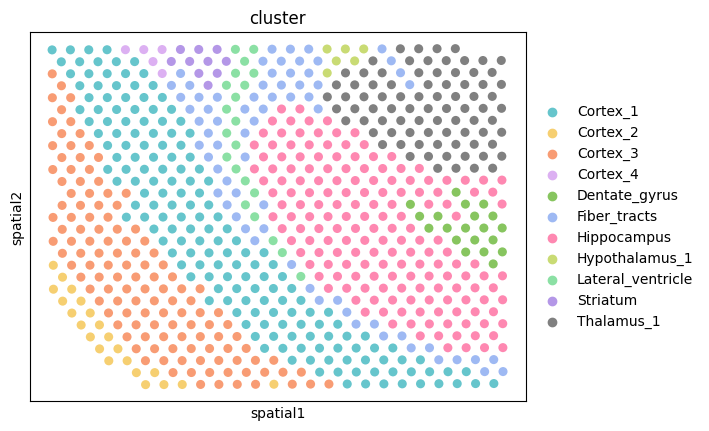

In [13]:
# Visualize embedding base on 'spatial' with points colored by 'cluster' label 
sc.pl.embedding(adata_st,basis='spatial',color='cluster')

In [14]:
# select a subset based on the "Cortex_{i}" of 'adata_st.obs.cluster'
# And creates a copy of the resulting subset

adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()

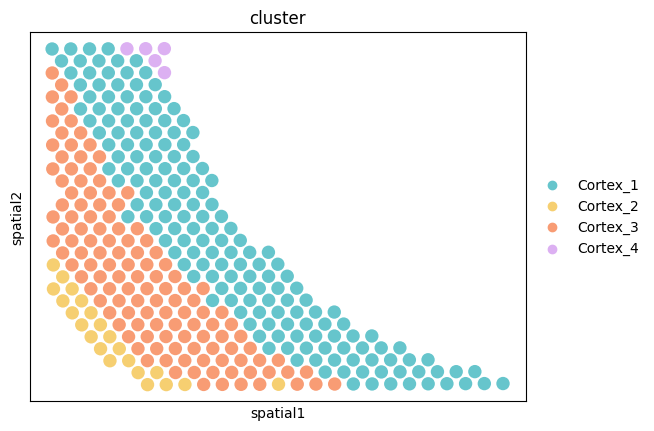

In [15]:
# Visualize embedding base on 'spatial' with points colored by a new 'cluster' label 
sc.pl.embedding(adata_st,basis='spatial',color='cluster')

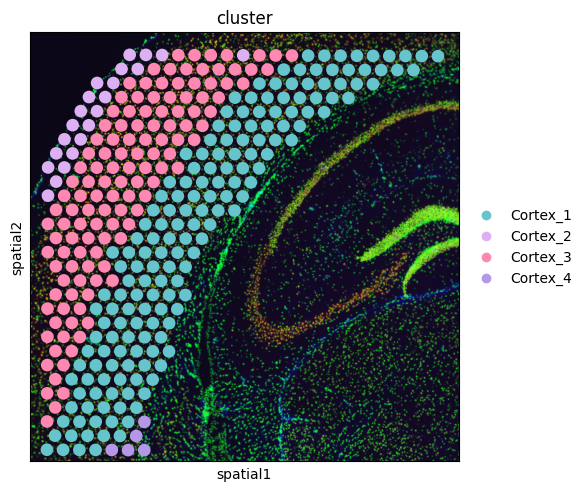

In [16]:
cmp_ct = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
cmp_ct_cmp = ListedColormap(cmp_ct)

ax = sq.pl.spatial_scatter(adata_st,color='cluster',size=1.2,palette=cmp_ct_cmp)

In [17]:
# Perform differential gene expression analysis across 'cell_subclasses' in 'adata_sc'
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)

In [18]:
# Create a Pandas DataFrame called "markers_df" by extracting the top 100 differentially expressed genes from 'adata_sc'
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# Create a NumPy array called "genes_sc" by extracting the unique values from the "value" column of a melted version of the "markers_df" 
genes_sc = np.unique(markers_df.melt().value.values)
# Extracte the names of genes from "adata_st"
genes_st = adata_st.var_names.values
# Create a Python list called "genes" 
# Contain the intersection of genes identified as differentially expressed in  "genes_sc" and genes detected in "genes_st".
genes = list(set(genes_sc).intersection(set(genes_st)))
# The length of "genes"
len(genes)

1281

## Perform Tangram for alignment

In [19]:
# Use the Tangram to align the gene expression profiles of "adata_sc" and "adata_st" based on the shared set of genes identified by the intersection of "genes_sc" and "genes_st".
tg.pp_adatas(adata_sc, adata_st, genes=genes)

INFO:root:1280 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [20]:
# Use the map_cells_to_space function from the tangram to map cells from "adata_sc" onto "adata_st". 
# The mapping use "cells" mode, which assign each cell from adata_sc to a location within the spatial transcriptomics space based on its gene expression profile.
ad_map = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    mode="cells",
    # target_count=adata_st.obs.cell_count.sum(),
    # density_prior=np.array(adata_st.obs.cell_count) / adata_st.obs.cell_count.sum(),
    num_epochs=1000,
    device="cpu",
)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.738, KL reg: 0.000
Score: 0.738, KL reg: 0.000


INFO:root:Saving results..


In [21]:
ad_map

AnnData object with n_obs × n_vars = 21697 × 324
    obs: 'sample_name', 'organism', 'donor_sex', 'cell_class', 'cell_subclass', 'cell_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [22]:
# Project "Cell_subclass" annotations from a single-cell RNA sequencing (scRNA-seq) dataset onto a spatial transcriptomics dataset, based on a previously computed cell-to-space mapping
tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [23]:
# Transfer cell type predictions from the AnnData object's ‘obsm’ attribute (adata_st.obsm['tangram_ct_pred']) to its observation metadata (adata_st.obs)
for ct in adata_st.obsm['tangram_ct_pred'].columns:
    adata_st.obs[ct] = np.array(adata_st.obsm['tangram_ct_pred'][ct].values)

In [24]:
# Print adata_st.obsm['tangram_ct_pred']
adata_st.obsm['tangram_ct_pred']

Pvalb         L4        Vip    L2/3 IT     Lamp5  \
AAATGGCATGTCTTGT-1  7.004985   1.548934   6.902157   0.001669  4.129408   
AACAACTGGTAGTTGC-1  4.209501   0.000783  13.903717   0.192844  4.696000   
AACAGGAAATCGAATA-1  4.682822   0.526977   7.370772   0.571306  6.074437   
AACCCAGAGACGGAGA-1  8.718892   4.313211   4.679913   3.914560  8.065018   
AACCGTTGTGTTTGCT-1  8.815555   5.802182   4.890625   1.156238  5.074965   
...                      ...        ...        ...        ...       ...   
TTGGATTGGGTACCAC-1  5.916564   2.063360  13.772404   1.952126  2.691196   
TTGGCTCGCATGAGAC-1  2.514913   4.281378   4.322568  10.849935  8.974291   
TTGTATCACACAGAAT-1  3.621018   0.001693   6.560889   1.507911  5.990241   
TTGTGGCCCTGACAGT-1  9.345364   2.639463   9.780218   0.001793  0.349541   
TTGTTAGCAAATTCGA-1  4.926483  22.468429   5.517707   0.864528  1.313571   

                          NP        Sst      L5 IT     Oligo      L6 CT  ...  \
AAATGGCATGTCTTGT-1  4.114066   3.220240   3.820235  0.288011   8.503994  ...   
AACAACTGGTAGTTGC-1  3.499797   6.033508   9.985192  0.456206   2.967823  ...   
AACAGGAAATCGAATA-1  1.000437   7.754989   5.081327  0.396358  15.313167  ...   
AACCCAGAGACGGAGA-1  0.000336   7.402516   9.868730  0.476459   2.293070  ...   
AACCGTTGTGTTTGCT-1  0.487821   8.204679  14.393296  1.581857   0.000475  ...   
...                      ...        ...        ...       ...        ...  ...   
TTGGATTGGGTACCAC-1  2.123059  12.909450   9.272922  0.410706   0.005365  ...   
TTGGCTCGCATGAGAC-1  0.000461  13.464813   9.720862  0.139286   0.609628  ...   
TTGTATCACACAGAAT-1  4.790297   8.296551   8.652060  0.563544   5.002628  ...   
TTGTGGCCCTGACAGT-1  0.998307   4.595858   5.134462  0.792228   7.001610  ...   
TTGTTAGCAAATTCGA-1  0.000482   5.217501  12.868741  0.667749   0.740462  ...   

                       L5 PT     Astro       L6b      Endo      Peri  \
AAATGGCATGTCTTGT-1  7.850845  2.551129  0.000456  0.421885  0.000057   
AACAACTGGTAGTTGC-1  7.369421  1.928740  0.928254  0.526186  0.107533   
AACAGGAAATCGAATA-1  1.394540  2.027951  0.473381  0.544031  0.228793   
AACCCAGAGACGGAGA-1  0.230093  2.908436  0.000443  0.586561  0.000053   
AACCGTTGTGTTTGCT-1  2.226670  1.070311  1.225542  1.491899  0.074052   
...                      ...       ...       ...       ...       ...   
TTGGATTGGGTACCAC-1  6.397924  2.403446  0.000223  0.458006  0.038058   
TTGGCTCGCATGAGAC-1  0.000646  0.838765  0.076363  0.416698  0.059241   
TTGTATCACACAGAAT-1  3.863253  0.750675  1.071313  0.396808  0.058517   
TTGTGGCCCTGACAGT-1  4.198365  2.206220  1.493556  0.653867  0.068874   
TTGTTAGCAAATTCGA-1  0.435651  1.406598  0.000301  0.509059  0.103536   

                       Meis2  Macrophage        CR      VLMC       SMC  
AAATGGCATGTCTTGT-1  0.000061    1.297545  0.071324  0.129917  0.685547  
AACAACTGGTAGTTGC-1  0.000130    0.547133  0.079866  0.000185  0.275435  
AACAGGAAATCGAATA-1  1.153768    0.685693  0.000441  0.000177  0.262540  
AACCCAGAGACGGAGA-1  0.475399    0.902312  0.000050  0.578500  0.581497  
AACCGTTGTGTTTGCT-1  0.000590    0.215931  0.055336  0.000093  0.551992  
...                      ...         ...       ...       ...       ...  
TTGGATTGGGTACCAC-1  0.000083    0.227499  0.018278  0.252095  0.642331  
TTGGCTCGCATGAGAC-1  0.025889    0.272974  0.000290  0.260999  0.389371  
TTGTATCACACAGAAT-1  0.034917    0.193589  0.000341  0.272419  0.238980  
TTGTGGCCCTGACAGT-1  0.000080    0.696597  0.000134  0.323000  0.212188  
TTGTTAGCAAATTCGA-1  0.436183    0.113370  0.000399  0.191394  0.058175  

[324 rows x 23 columns]

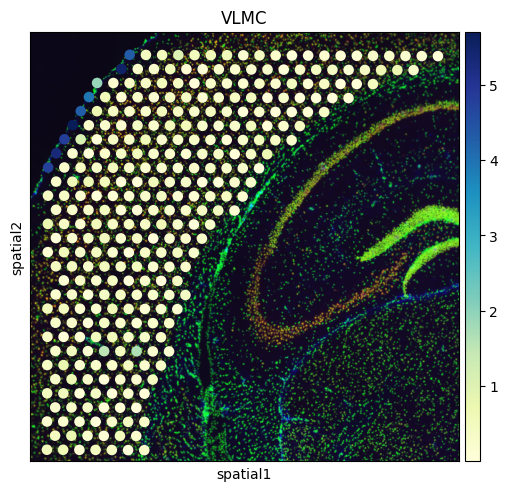

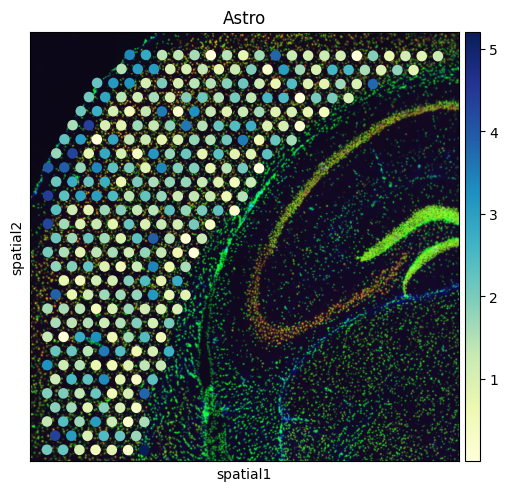

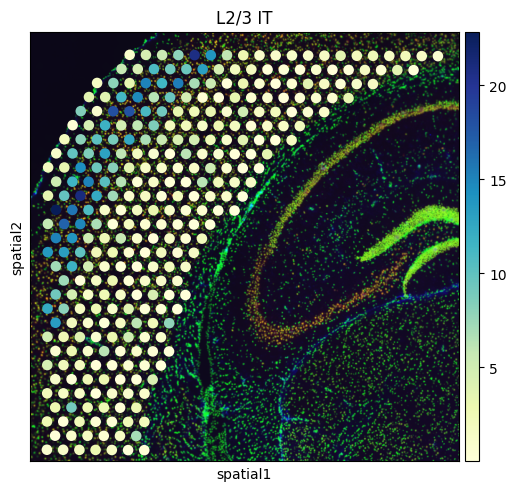

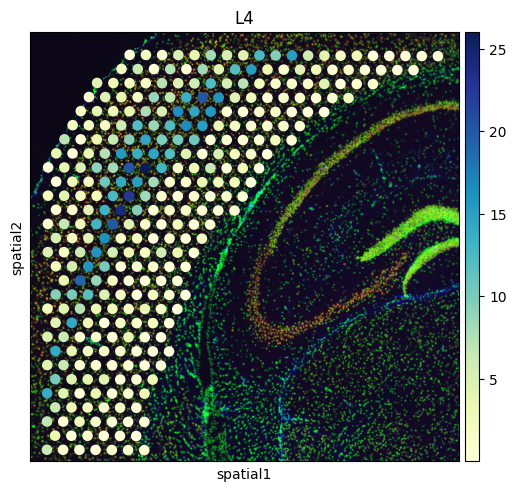

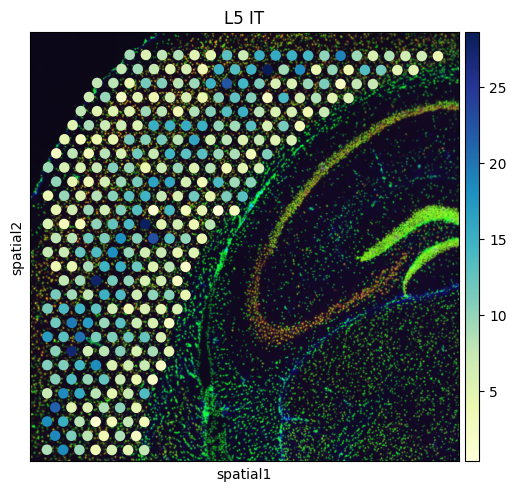

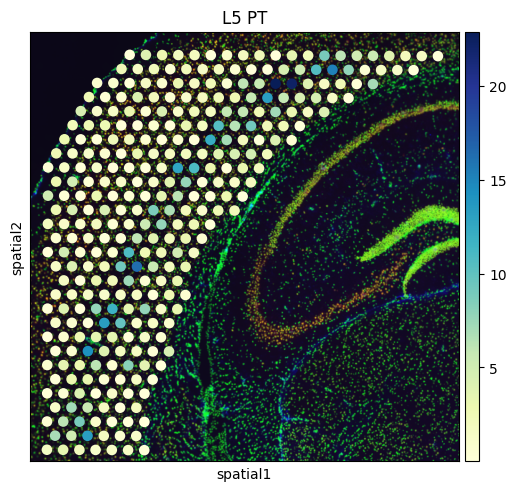

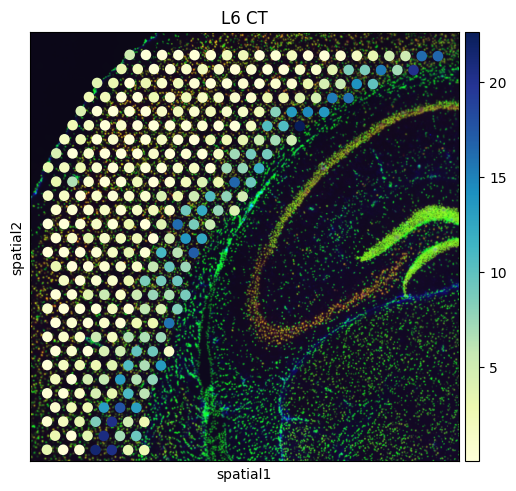

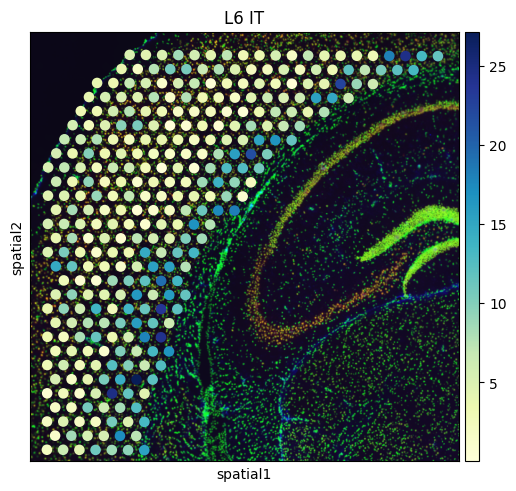

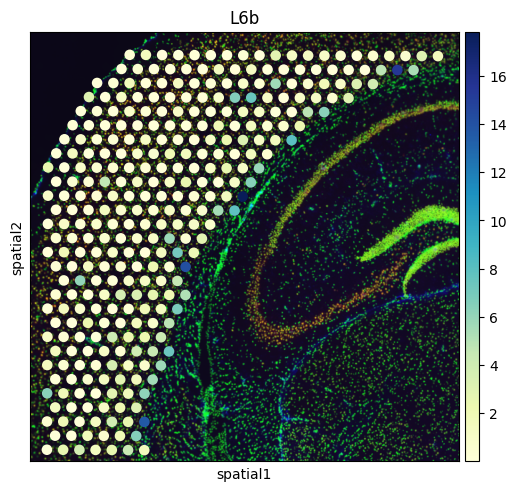

In [25]:
# Create a spatial embedding plot that visualizes the distribution of diverse cell types
from palettable.colorbrewer.sequential import YlGnBu_9
to_plot_list = ['VLMC','Astro',"L2/3 IT", "L4", "L5 IT", "L5 PT", "L6 CT", "L6 IT", "L6b"]

for to_plot in to_plot_list:
    sq.pl.spatial_scatter(
        adata_st,

        color=to_plot,
        cmap=YlGnBu_9.mpl_colormap
    )
    to_plot = to_plot.replace('/','_')
    to_plot = to_plot.replace(' ','_')